# Homework 2
通过Runge-Kutta法模拟计算静息电位
$$
C \frac{d V}{d t}=I_{e x t}-g_{N a} m^3 h\left(V-V_{N a}\right)-g_K n^4\left(V-V_K\right)-g_L\left(V-V_L\right)
$$
$\mathrm{Na}^{+}$ activation Units: $$\tau_m \frac{d m}{d t}=-m+m_{\infty}(V), \quad \tau_m=\frac{1}{\alpha_m+\beta_m}, m_{\infty}=\frac{\alpha_m}{\alpha_m+\beta_m}$$
$\mathrm{Na}^{+}$ inactivation Units: $$\tau_h \frac{d h}{d t}=-h+h_{\infty}(V), \tau_h=\frac{1}{\alpha_h+\beta_h}, h_{\infty}=\frac{\alpha_h}{\alpha_h+\beta_h}$$
$\mathrm{K}^{+}$ activation Units: $$\tau_n \frac{d n}{d t}=-n+n_{\infty}(V), \tau_n=\frac{1}{\alpha_n+\beta_n}, n_{\infty}=\frac{\alpha_n}{\alpha_n+\beta_n}$$

$$\begin{aligned}
& \alpha_m(V)= \frac{0.1 \cdot(V+40)}{1-e^{-(V+40) / 10}} \\
& \beta_m(V)= 4 e^{-(V+65) / 18} \\
& \alpha_h(V)= 0.07 e^{-(V+65) / 20} \\
& \beta_h(V)= \frac{1}{e^{-(V+35) / 10}+1} \\
& \alpha_n(V)= \frac{0.01 \cdot(V+55)}{1-e^{-(V+55) / 10}} \\
& \beta_n(V)= 0.125 \cdot e^{-(V+65) / 80} \\
\end{aligned}$$

### Euler Method

In [1]:
import numpy as np

def alphabeta(v, m, h, n):
    gnax = 120  # mS/cm^2
    gkx = 36    # mS/cm^2
    glx = 0.3   # mS/cm^2
    
    # Alpha functions
    am = -0.1 * (40 + v) / (np.exp(-(40 + v) / 10) - 1)
    ah = 0.07 * np.exp(-(v + 65) / 20)
    an = -0.01 * (v + 55) / (np.exp(-(55 + v) / 10) - 1)
    
    # Beta functions
    bm = 4 * np.exp(-(v + 65) / 18)
    bh = 1 / (np.exp(-(35 + v) / 10) + 1)
    bn = 0.125 * np.exp(-(v + 65) / 80)
    
    # Conductance
    gna = gnax * m**3 * h
    gk = gkx * n**4
    gl = glx
    
    return am, ah, an, bm, bh, bn, gna, gk, gl

def HH_euler(dt, tfinal, Istim):
    vna = 50
    vk = -77
    vl = -54.4

    m = 0.05
    h = 0.6
    n = 0.3
    v = -70  
    t = 0
    i = 0
    results = []

    while t <= tfinal:
        i += 1
        t += dt
        if t < 50:
            signal = 0
        else:
            signal = Istim
        am, ah, an, bm, bh, bn, gna, gk, gl = alphabeta(v, m, h, n)
        n = n + (an * (1 - n) - bn * n) * dt
        m = m + (am * (1 - m) - bm * m) * dt
        h = h + (ah * (1 - h) - bh * h) * dt
        v = v + (signal - gna * (v - vna) - gk * (v - vk) - gl * (v - vl)) * dt
        results.append([t, v, m, h, n])

    return np.array(results)


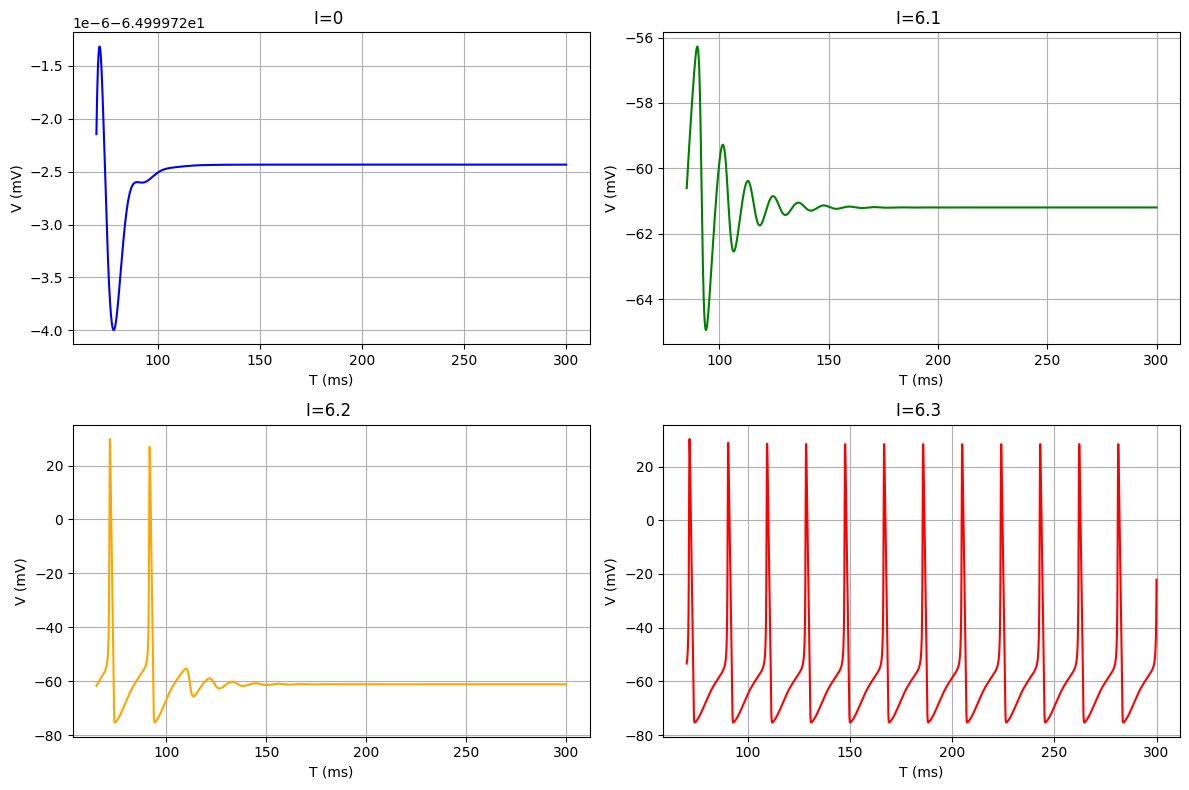

In [2]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import MultipleLocator
# Time step and simulation time
dt = 0.001  
tfinal = 300  
Istim_values = [0, 6.1, 6.2, 6.3]
delays = [int(70/dt),int(85/dt),int(65/dt),int(70/dt)]
colors = ['blue', 'green', 'orange', 'red']
titles = [f"I={Istim} " for Istim in Istim_values]
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# Plot the results for each Istim value in different subplots
for idx, Istim in enumerate(Istim_values):
    results = HH_euler(dt, tfinal, Istim)
    t = results[delays[idx]:, 0]  
    v = results[delays[idx]:, 1]  
    ax = axs[idx // 2, idx % 2]
    ax.plot(t, v, label=f'Istim={Istim} μA/cm²', color=colors[idx])
    ax.set_xlabel('T (ms)')
    ax.set_ylabel('V (mV)')
    ax.set_title(titles[idx])
    ax.grid(True)

# Adjust the layout
plt.tight_layout()
plt.show()


### Runge-Kutta Method

In [2]:
import numpy as np

def alphabeta(v, m, h, n):
    gnax = 120  
    gkx = 36   
    glx = 0.3  
    
    # Alpha functions
    am = -0.1 * (40 + v) / (np.exp(-(40 + v) / 10) - 1)
    ah = 0.07 * np.exp(-(v + 65) / 20)
    an = -0.01 * (v + 55) / (np.exp(-(55 + v) / 10) - 1)
    
    # Beta functions
    bm = 4 * np.exp(-(v + 65) / 18)
    bh = 1 / (np.exp(-(35 + v) / 10) + 1)
    bn = 0.125 * np.exp(-(v + 65) / 80)
    
    # Conductance
    gna = gnax * m**3 * h
    gk = gkx * n**4
    gl = glx
    
    return am, ah, an, bm, bh, bn, gna, gk, gl

def HH_RK4(dt, tfinal, Istim):
    vna = 50
    vk = -77
    vl = -54.4

    m = 0.05
    h = 0.6
    n = 0.3
    v = -70  

    t = 0
    i = 0
    results = []

    def dmdt(v, m):
        am, _, _, bm, _, _, _, _, _ = alphabeta(v, m, h, n)
        return am * (1 - m) - bm * m

    def dhdt(v, h):
        _, ah, _, _, bh, _, _, _, _ = alphabeta(v, m, h, n)
        return ah * (1 - h) - bh * h

    def dndt(v, n):
        _, _, an, _, _, bn, _, _, _ = alphabeta(v, m, h, n)
        return an * (1 - n) - bn * n

    def dvdt(v, m, h, n, signal):
        _, _, _, _, _, _, gna, gk, gl = alphabeta(v, m, h, n)
        return signal - gna * (v - vna) - gk * (v - vk) - gl * (v - vl)

    while t <= tfinal:
        i += 1
        t += dt

        # Apply stimulus after t = 1 ms
        if t < 50:
            signal = 0
        else:
            signal = Istim

        kv1 = dvdt(v, m, h, n, signal) * dt
        km1 = dmdt(v, m) * dt
        kh1 = dhdt(v, h) * dt
        kn1 = dndt(v, n) * dt

        kv2 = dvdt(v + kv1 / 2, m + km1 / 2, h + kh1 / 2, n + kn1 / 2, signal) * dt
        km2 = dmdt(v + kv1 / 2, m + km1 / 2) * dt
        kh2 = dhdt(v + kv1 / 2, h + kh1 / 2) * dt
        kn2 = dndt(v + kv1 / 2, n + kn1 / 2) * dt

        kv3 = dvdt(v + kv2 / 2, m + km2 / 2, h + kh2 / 2, n + kn2 / 2, signal) * dt
        km3 = dmdt(v + kv2 / 2, m + km2 / 2) * dt
        kh3 = dhdt(v + kv2 / 2, h + kh2 / 2) * dt
        kn3 = dndt(v + kv2 / 2, n + kn2 / 2) * dt

        kv4 = dvdt(v + kv3, m + km3, h + kh3, n + kn3, signal) * dt
        km4 = dmdt(v + kv3, m + km3) * dt
        kh4 = dhdt(v + kv3, h + kh3) * dt
        kn4 = dndt(v + kv3, n + kn3) * dt

        v = v + (kv1 + 2 * kv2+ 2 * kv3 + kv4 )/6 
        m = m + (km1 + 2 * km2 + 2 * km3 + km4)/6
        h = h + (kh1 + 2 * kh2 + 2 * kh3 + kh4)/6
        n = n + (kn1 + 2 * kn2 + 2 * kn3 + kn4)/6
        results.append([t, v, m, h, n])

    return np.array(results)


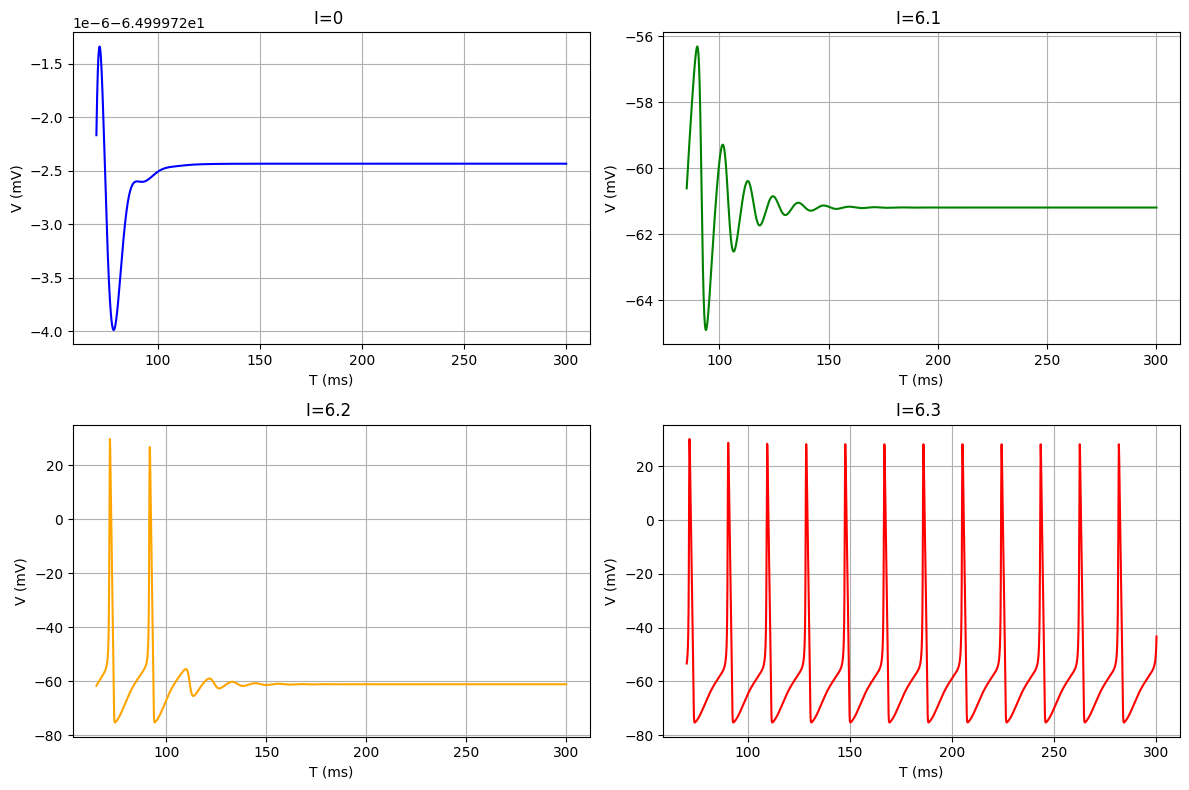

In [4]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import MultipleLocator
# Time step and simulation time
dt = 0.01  # ms
tfinal = 300  # ms

Istim_values = [0, 6.1, 6.2, 6.3]
colors = ['blue', 'green', 'orange', 'red']
titles = [f"I={Istim} " for Istim in Istim_values]
delays = [int(70/dt),int(85/dt),int(65/dt),int(70/dt)]
# Create a figure with subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
for idx, Istim in enumerate(Istim_values):
    results = HH_RK4(dt, tfinal, Istim)
    t = results[delays[idx]:, 0]  
    v = results[delays[idx]:, 1]
    
    # Select the appropriate subplot
    ax = axs[idx // 2, idx % 2]
    ax.plot(t, v, label=f'Istim={Istim} μA/cm²', color=colors[idx])
    
    # Set labels and titles
    ax.set_xlabel('T (ms)')
    ax.set_ylabel('V (mV)')
    ax.set_title(titles[idx])
    ax.grid(True)

# Adjust the layout
plt.tight_layout()
plt.show()


---

尝试通过HH模型spike train计算Spike-Triggered Average

### Spike-Triggered Average

In [22]:
import numpy as np

def sta(stim, spikes, N):
    out = []
    out_append = []
    n = 0

    # 遍历每一个 spike
    for i in range(len(spikes)):
        if spikes[i] > 0 and i > N and i+N < len(spikes):
            n += 1
            # 提取当前刺激序列的窗口
            out.append(stim[i-N:i])
            out_append.append(stim[i:i+N])

    # 将 out 转换为 NumPy 数组
    out = np.array(out)
    out_append = np.array(out_append)

    # 计算 kernel 和 kerr
    kernel = np.mean(out, axis=0)
    kerr = np.std(out, axis=0)
    
    kernel_append = np.mean(out_append, axis=0)
    kerr_append = np.std(out_append, axis=0)

    return kernel, kerr, out, kernel_append, kerr_append, out_append


In [4]:
import numpy as np

def alphabeta(v, m, h, n):
    gnax = 120 
    gkx = 36   
    glx = 0.3  
    
    # Alpha functions
    am = -0.1 * (40 + v) / (np.exp(-(40 + v) / 10) - 1)
    ah = 0.07 * np.exp(-(v + 65) / 20)
    an = -0.01 * (v + 55) / (np.exp(-(55 + v) / 10) - 1)
    
    # Beta functions
    bm = 4 * np.exp(-(v + 65) / 18)
    bh = 1 / (np.exp(-(35 + v) / 10) + 1)
    bn = 0.125 * np.exp(-(v + 65) / 80)
    
    # Conductance
    gna = gnax * m**3 * h
    gk = gkx * n**4
    gl = glx
    
    return am, ah, an, bm, bh, bn, gna, gk, gl

def HH_RK4_spike(dt, tfinal, Istim_array):
    vna = 50
    vk = -77
    vl = -54.4

    m = 0.05
    h = 0.6
    n = 0.3
    v = -70 

    t = 0
    i = 0

    results = []
    spikes = []
    def dmdt(v, m):
        am, _, _, bm, _, _, _, _, _ = alphabeta(v, m, h, n)
        return am * (1 - m) - bm * m

    def dhdt(v, h):
        _, ah, _, _, bh, _, _, _, _ = alphabeta(v, m, h, n)
        return ah * (1 - h) - bh * h

    def dndt(v, n):
        _, _, an, _, _, bn, _, _, _ = alphabeta(v, m, h, n)
        return an * (1 - n) - bn * n

    def dvdt(v, m, h, n, signal):
        _, _, _, _, _, _, gna, gk, gl = alphabeta(v, m, h, n)
        return signal - gna * (v - vna) - gk * (v - vk) - gl * (v - vl)

    while t < tfinal:
        t += dt
        signal = Istim_array[i]
        kv1 = dvdt(v, m, h, n, signal) * dt
        km1 = dmdt(v, m) * dt
        kh1 = dhdt(v, h) * dt
        kn1 = dndt(v, n) * dt

        kv2 = dvdt(v + kv1 / 2, m + km1 / 2, h + kh1 / 2, n + kn1 / 2, signal) * dt
        km2 = dmdt(v + kv1 / 2, m + km1 / 2) * dt
        kh2 = dhdt(v + kv1 / 2, h + kh1 / 2) * dt
        kn2 = dndt(v + kv1 / 2, n + kn1 / 2) * dt

        kv3 = dvdt(v + kv2 / 2, m + km2 / 2, h + kh2 / 2, n + kn2 / 2, signal) * dt
        km3 = dmdt(v + kv2 / 2, m + km2 / 2) * dt
        kh3 = dhdt(v + kv2 / 2, h + kh2 / 2) * dt
        kn3 = dndt(v + kv2 / 2, n + kn2 / 2) * dt

        kv4 = dvdt(v + kv3, m + km3, h + kh3, n + kn3, signal) * dt
        km4 = dmdt(v + kv3, m + km3) * dt
        kh4 = dhdt(v + kv3, h + kh3) * dt
        kn4 = dndt(v + kv3, n + kn3) * dt

        # Update membrane potential and gating variables
        v = v + (kv1 + 2 * kv2+ 2 * kv3 + kv4 )/6 
        m = m + (km1 + 2 * km2 + 2 * km3 + km4)/6
        h = h + (kh1 + 2 * kh2 + 2 * kh3 + kh4)/6
        n = n + (kn1 + 2 * kn2 + 2 * kn3 + kn4)/6
        # Detect spikes (when membrane potential crosses 0 mV)
        # if v > 0 and not spike_detected:
        #     spikes.append(1)  # Only append spike once when v crosses 0
        #     spike_detected = True
        # elif v <= 0:
        #     spikes.append(0)
        #     spike_detected = False  # Reset when the potential drops back to negative


        # Store the results
        results.append([t, v, m, h, n])
        i += 1
    
    # threhold
    results = np.array(results)
    mean = np.mean(results[:,1])
    std = np.std(results[:,1])
    threshold = mean + 1 * std  # k = 1
    temp = threshold
    for item in results[:,1]:
        if item > threshold:
            if item>temp:
                spikes[-1] = 0
                spikes.append(1)
            else:
                spikes.append(0)
        else:
            spikes.append(0)
    # Convert results to NumPy array for easier manipulation
    return np.array(results),np.array(spikes)


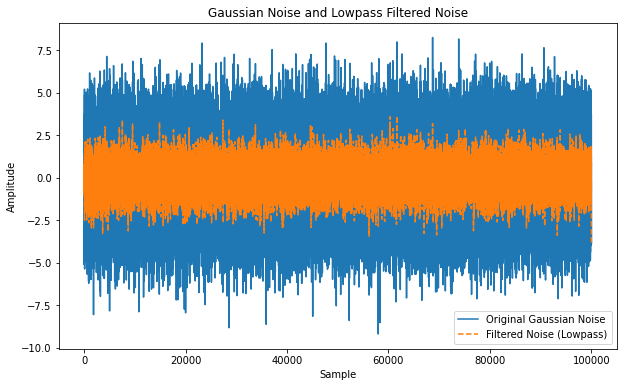

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt

# 生成高斯噪声
def generate_gaussian_noise(size, mean=0, std_dev=1):
    noise = np.random.normal(mean, std_dev, size)
    return noise

# 低通滤波器设计
def butter_lowpass_filter(data, cutoff, fs, order=4):
    nyquist = 0.5 * fs  # 奈奎斯特频率
    normal_cutoff = cutoff / nyquist  # 归一化截止频率
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    filtered_data = filtfilt(b, a, data)
    return filtered_data

# def butter_highpass_filter(data, cutoff, fs, order=4):
#     nyquist = 0.5 * fs  # 奈奎斯特频率
#     normal_cutoff = cutoff / nyquist  # 归一化截止频率
#     b, a = butter(order, normal_cutoff, btype='high', analog=False)
#     filtered_data = filtfilt(b, a, data)
#     return filtered_data

# 生成噪声信号
dt = 0.1  # Time step
tfinal = 10000  # Total simulation time (ms)
fs = int(1/dt)  # 采样频率
cutoff = 1  # 截止频率
noise = generate_gaussian_noise(int(tfinal / dt)+1)*2

# 应用低通滤波器
filtered_noise = butter_lowpass_filter(noise, cutoff, fs)

# 可视化原始噪声和滤波后的噪声
plt.figure(figsize=(10, 6))
plt.plot(noise, label='Original Gaussian Noise')
plt.plot(filtered_noise, label='Filtered Noise (Lowpass)', linestyle='--')
plt.title('Gaussian Noise and Lowpass Filtered Noise')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.legend()
plt.show()


In [8]:
stim = noise

In [9]:
results, spikes = HH_RK4_spike(dt, tfinal, stim)

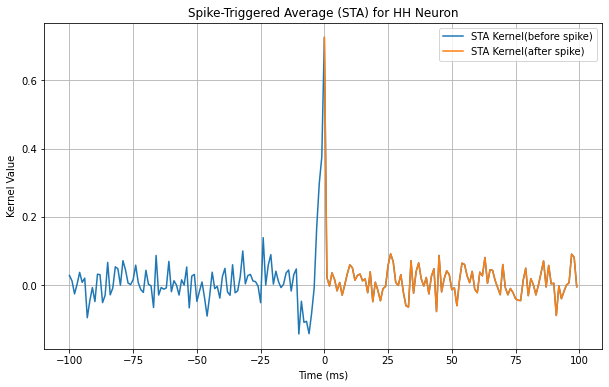

In [54]:
# Calculate Spike-Triggered Average (STA), sample_space = 5
T = 100
N = int(T/dt)  # Window size for STA (100 ms)
kernel, kerr,out, kernel_append, kerr_append, out_append = sta(stim, spikes, N)
Tt = np.arange(-T,0,dt)
Tt_append = np.arange(0,T,dt)
sample_space = 10
kernel = kernel[::sample_space]
kernel_append = kernel_append[::sample_space]
Tt = Tt[::sample_space]
Tt_append = Tt_append[::sample_space]
concat_kernel = np.concatenate((kernel,kernel_append))
concat_Tt = np.concatenate((Tt,Tt_append))
# Plotting the results
plt.figure(figsize=(10, 6))
# Plot STA kernel

plt.plot(concat_Tt ,concat_kernel, label='STA Kernel(before spike)')
plt.plot(Tt_append ,kernel_append, label='STA Kernel(after spike)')
plt.title('Spike-Triggered Average (STA) for HH Neuron')
plt.xlabel('Time (ms)')
plt.ylabel('Kernel Value')
plt.legend()
plt.grid(True)
plt.show()

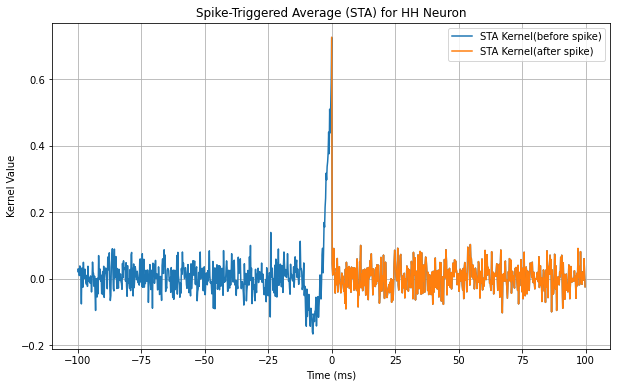

In [53]:
# Calculate Spike-Triggered Average (STA)
T = 100
N = int(T/dt)  # Window size for STA (100 ms)
kernel, kerr,out, kernel_append, kerr_append, out_append = sta(stim, spikes, N)
Tt = np.arange(-T,0,dt)
Tt_append = np.arange(0,T,dt)
sample_space = 2
kernel = kernel[::sample_space]
kernel_append = kernel_append[::sample_space]
Tt = Tt[::sample_space]
Tt_append = Tt_append[::sample_space]
concat_kernel = np.concatenate((kernel,kernel_append))
concat_Tt = np.concatenate((Tt,Tt_append))
# Plotting the results
plt.figure(figsize=(10, 6))
# Plot STA kernel

plt.plot(concat_Tt ,concat_kernel, label='STA Kernel(before spike)')
plt.plot(Tt_append ,kernel_append, label='STA Kernel(after spike)')
plt.title('Spike-Triggered Average (STA) for HH Neuron')
plt.xlabel('Time (ms)')
plt.ylabel('Kernel Value')
plt.legend()
plt.grid(True)
plt.show()